# Amazon, modelo supervisado

## Importar

In [51]:
# %load basic
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',200)
pd.options.display.float_format = '{:.2f}'.format
liga = '/Users/efraflores/Desktop/EF/diplo/AZ/data/'
os.listdir(liga)

['resultado_modelo_cont_v1.csv', 'sentim.csv', 'df_cluster.csv', 'df.csv']

In [52]:
df = pd.read_csv(liga + 'df_cluster.csv', low_memory = False)
df = df.drop(columns = ['vote','image']).dropna().reset_index(drop = True)
df = df[(df['Anio'] >= 2006) & (df['Anio'] <= 2016)].copy()
backup = df.copy()
df.sample()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,category,Anio,Mes,Sem,DiaSem,reviewText_limpio,reviewText_long,reviewText_n_words,reviewText_relevant,neg,neu,pos,compound,df_cluster
275365,3.00,True,2012-04-28,A3CG4N3WC8J6D4,B0068XJXJC,Susan M. Baganz,I had read the negative reviews and to reitera...,A sweet novella - but some head-hopping,0 days,No_especifica,kindle_store,2012,abr,17,sab,read negative review reiterate novella short s...,914.00,183.00,0.53,0.14,0.58,0.29,0.92,F


In [53]:
df.describe([i/10 for i in range(10)] + [.05,.95])

,overall,Anio,Sem,reviewText_long,reviewText_n_words,reviewText_relevant,neg,neu,pos,compound
count,629378.00,629378.00,629378.00,629378.00,629378.00,629378.00,629378.00,629378.00,629378.00,629378.00
mean,4.22,2012.81,26.14,536.33,97.61,0.65,0.07,0.55,0.38,0.65
std,1.14,2.37,15.59,949.01,168.50,0.12,0.10,0.17,0.19,0.46
min,1.00,2006.00,1.00,5.00,2.00,0.04,0.00,0.00,0.00,-1.00
0%,1.00,2006.00,1.00,5.00,2.00,0.04,0.00,0.00,0.00,-1.00
5%,1.00,2008.00,3.00,21.00,4.00,0.50,0.00,0.29,0.00,-0.48
10%,2.00,2009.00,5.00,32.00,6.00,0.53,0.00,0.34,0.15,0.00
20%,3.00,2011.00,10.00,91.00,17.00,0.56,0.00,0.41,0.22,0.44
30%,4.00,2012.00,15.00,135.00,25.00,0.58,0.00,0.46,0.27,0.62
40%,4.00,2013.00,20.00,169.00,32.00,0.60,0.00,0.51,0.32,0.77


## Funciones

In [54]:
import time
import math

start = time.time()

def time_exp(x):
    print(str(int(math.floor(x/60))
             ) + " minutos con " + '{:.2f}'.format(60*(x/60 - math.floor(x/60))
                                                  ) + " segundos")

In [55]:
from IPython.lib.display import Audio
import numpy as np

#Tono para cuando termina el script
def tono(a = 1000, b = 700, play_time_seconds = 1, framerate = 4410,):
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t) + np.sin(b*t), rate = framerate, autoplay=True)

In [56]:
def outlier(df, x , p = 0.5):
    var = df[x]
    q1 = var.quantile(p/2)
    q3 = var.quantile(1 - p/2)
    iqr = q3 - q1
    df = df[(var.isnull()) | ((var >= q1 - 1.5*iqr) & (var <= q3 + 1.5*iqr))].copy()
    return df

In [57]:
def multishift(df, 
               fecha = 'reviewTime',
               target = 'pos',
               func = 'mean',
               n = 15):
    
    #DF con todas y cada una de las fechas posibles según las fechas del DF original
    tot_dates = pd.DataFrame(pd.date_range(start = df[fecha].min(), 
                                           end = df[fecha].max()).date, 
                             columns = [fecha]).astype(str)
    
    #Count condicional de la variable target
    aux = df.pivot_table(index = fecha,
                         values = target, 
                         aggfunc = func
                        ).rename(columns = {target:'target'})
    
    #Pivot del resto de las variables numéricas con la función indicada
    df = df.pivot_table(index = fecha, aggfunc = func).join(aux.shift(-1)) #one day ahead
    
    #Se une con el total de fechas para no omitir ningún día
    df = tot_dates.merge(df, on = fecha, how = 'left').fillna(0)
    
    #Ciclo para agregar el valor de la target original (no el count) hasta n días atrás
    for i in range(1,n+1):
        df = df.join(df[[target]].shift(i).rename(columns = 
                                                  {target:f'{target}_{str(i).zfill(2)}'}))
    
    for i in range(2,n+1):
        df[f'roll_{i}'] = df[[x for x in df.columns if x.startswith(f'{target}_') 
                              and int(x[-2:]) <= i]].median(axis = 1)
        
    #No es necesario contar con los primeros n registros dado el ciclo de shifts
    return df.iloc[n:,:]

In [58]:
def tad_multicat(df,cat_col):
    total = pd.DataFrame()
    for cat in set(df[cat_col]):
        aux = multishift(df[df[cat_col] == cat])
        aux['category'] = cat
        total = total.append(aux, ignore_index = True)
    return total

In [59]:
def fechas(df, fecha, formato = "%Y-%m-%d"):
    df = df.copy()
    df[fecha] = pd.to_datetime(df[fecha], format = formato)
    df['Anio'] = df[fecha].dt.year
    meses = ['ene','feb','mar','abr','may','jun',
             'jul','ago','sep','oct','nov','dic']
    meses = dict(zip(range(1,13),meses))
    #Mes en formato MMM (español)
    df['Mes'] = df[fecha].dt.month.replace(meses)
    df['Sem'] = df[fecha].dt.isocalendar().week
    diasem = ['lun','mar','mie','jue','vie','sab','dom']
    diasem = dict(zip(range(7),diasem))
    #Día de la semana en formato DDD (español)
    df['DiaSem'] = df[fecha].dt.dayofweek.replace(diasem)
    return df

## TAD

In [60]:
#df = fechas(tad_multicat(df,'category'), fecha = 'reviewTime')
df = fechas(multishift(df), fecha = 'reviewTime')
df.sample(4)

,reviewTime,Anio,Sem,compound,neg,neu,overall,pos,reviewText_long,reviewText_n_words,reviewText_relevant,verified,target,pos_01,pos_02,pos_03,pos_04,pos_05,pos_06,pos_07,pos_08,pos_09,pos_10,pos_11,pos_12,pos_13,pos_14,pos_15,roll_2,roll_3,roll_4,roll_5,roll_6,roll_7,roll_8,roll_9,roll_10,roll_11,roll_12,roll_13,roll_14,roll_15,Mes,DiaSem
2322,2012-05-11,2012,19,0.71,0.09,0.57,4.24,0.34,736.13,132.61,0.61,0.68,0.34,0.33,0.33,0.34,0.35,0.32,0.35,0.34,0.34,0.33,0.31,0.32,0.35,0.30,0.32,0.32,0.33,0.33,0.33,0.33,0.33,0.34,0.34,0.34,0.33,0.33,0.33,0.33,0.33,0.33,may,vie
3681,2016-01-30,2016,4,0.60,0.06,0.52,4.50,0.43,305.64,54.72,0.71,0.92,0.44,0.45,0.39,0.43,0.41,0.43,0.42,0.43,0.45,0.44,0.44,0.43,0.46,0.41,0.44,0.45,0.42,0.43,0.42,0.43,0.42,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,ene,sab
1974,2011-05-29,2011,21,0.75,0.10,0.58,4.19,0.32,832.92,152.22,0.59,0.59,0.30,0.32,0.33,0.31,0.31,0.30,0.32,0.30,0.30,0.33,0.32,0.34,0.35,0.31,0.35,0.35,0.32,0.32,0.32,0.31,0.31,0.31,0.31,0.31,0.31,0.32,0.32,0.32,0.32,0.32,may,dom
563,2007-07-18,2007,29,0.65,0.12,0.62,3.86,0.26,1829.95,329.86,0.59,0.07,0.33,0.30,0.32,0.30,0.27,0.32,0.31,0.30,0.30,0.29,0.30,0.30,0.29,0.31,0.29,0.32,0.31,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,jul,mie


## Modelo

### f(X) = y

In [61]:
df['target'] = pd.qcut(df['target'], q = 2, duplicates = 'drop').astype(str)
df['target'].value_counts(1)

(-0.001, 0.333]   0.50
(0.333, 0.577]    0.50
Name: target, dtype: float64

In [62]:
df.drop(columns = 'reviewTime', inplace = True)

num = [x for x in df.describe().columns if x not in ['target']]
cat = [x for x in df.columns if x not in num + ['target']]
df = df[cat+num+['target']].copy()

X = df[cat + num].copy()
y = df['target']

### Preprocesamiento

In [63]:
from sklearn.preprocessing import LabelEncoder
label_encod = LabelEncoder()
y = label_encod.fit_transform(y)

np.unique(y)

array([0, 1])

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.77, 
                                                    random_state = 22)

In [65]:
#Encoder para categóricas
from category_encoders.cat_boost import CatBoostEncoder
encod = CatBoostEncoder()

#Escala para numéricas
from sklearn.preprocessing import MinMaxScaler
mm_x = MinMaxScaler()

#Se aplicará transformación para cada tipo de columnas
from sklearn.compose import ColumnTransformer
prep = ColumnTransformer(transformers=[('Cat_encod', encod, cat),
                                       ('Scale', mm_x, num)])

### Ensamble

In [66]:
scoring = 'roc_auc' if len(set(y)) == 2 else 'accuracy'

from sklearn.ensemble import RandomForestClassifier 
forest = RandomForestClassifier()

param_forest = {'n_estimators': [x for x in range(100, 1000, 100)],
                'max_features': ['auto', 'sqrt', 'log2'],
                'criterion': ['gini', 'entropy'],
                'class_weight': ['balanced', None],
                'min_samples_split': [x for x in range(17, 22)],
                'min_samples_leaf': [x/100 for x in range(1, 6)]
               }

from sklearn.model_selection import RandomizedSearchCV
search_forest = RandomizedSearchCV(param_distributions = param_forest, 
                                   cv = 4, 
                                   n_jobs = -1, 
                                   scoring = scoring,
                                   estimator = forest,
                                   verbose = 5,
                                   n_iter = 50,
                                   random_state = 22)

In [67]:
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier()

param_xgb = {'learning_rate':[x/100 for x in range(1,111)],
             'n_estimators':[x for x in range(1,111)],
             'max_depth':[x for x in range(1,11)], 
             'min_child_weight':[x for x in range(1,111)],
             'objective':['count:poisson','multi:softmax'],
             'subsample':[x/100 for x in range(50,111)], 
             'colsample_bytree':[x/100 for x in range(50,111)], 
            }

from sklearn.model_selection import RandomizedSearchCV
search_xgb = RandomizedSearchCV(param_distributions = param_xgb, 
                                cv = 4, 
                                n_jobs = -1, 
                                scoring = scoring, 
                                estimator = xgb, 
                                verbose = 5,
                                n_iter = 50,
                                random_state = 22)

In [68]:
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier(estimators = [('LogReg', search_forest), 
                                    ('XGB', search_xgb)], 
                      voting = 'soft')

In [69]:
from sklearn.pipeline import Pipeline
modelo = Pipeline(steps=[('preproc', prep),
                         ('modelo', vc)])

modelo.fit(X_train,y_train).score(X_test,y_test)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Fitting 4 folds for each of 50 candidates, totalling 200 fits


/Users/efraflores/Desktop/corner/corner/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.92202969 0.9297354         nan        nan 0.93306326
 0.92000536        nan        nan        nan 0.92378435        nan
        nan        nan 0.93388439        nan 0.92899038        nan
        nan        nan 0.93046443 0.92904503        nan        nan
 0.93289383 0.91809802        nan        nan        nan        nan
 0.91319994        nan        nan        nan        nan        nan
        nan        nan 0.93015994        nan        nan        nan
 0.92519875 0.91516981        nan        nan        nan        nan
        nan        nan]
  warnings.warn(
/Users/efraflores/Desktop/corner/corner/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass opt

0.8849077090119435

### Validación

'Accuracy de 88.49%'

<AxesSubplot:>

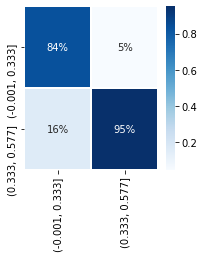

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = list(set(label_encod.inverse_transform(y)))[::-1]
cm = pd.DataFrame(confusion_matrix(y_true = y_test,
                                   y_pred = modelo.predict(X_test)), 
                  index = labels, 
                  columns = labels)

## Tiene buena acertividad (suma de diagonal en la matriz de confusión)
display('Accuracy de {:.2%}'.format(np.asarray(cm).trace()/len(y_test)))

fig, ax = plt.subplots(figsize=(3,3)) 
sns.heatmap(pd.DataFrame([cm[col]/cm[col].sum() for col in cm.columns]).transpose(), 
            annot = True,
            fmt = '.0%',
            cmap = 'Blues',
            linewidths = 0.5, 
            ax = ax)

In [71]:
pd.DataFrame(zip(df.columns, modelo[1].estimators_[1].best_estimator_.feature_importances_),
             columns = ['Variable',
                        'Importancia']).sort_values(by = 'Importancia', ascending = False
                                                   ).head(20).reset_index(drop = True)

,Variable,Importancia
0,roll_15,0.29
1,roll_10,0.14
2,Anio,0.10
3,roll_11,0.09
4,roll_12,0.09
5,reviewText_long,0.07
6,roll_2,0.05
7,roll_9,0.05
8,pos_03,0.03
9,verified,0.02


### Conservación

In [72]:
import pickle
with open('AZ_modelo_sup_disc_v1.pkl', "wb") as f:
    pickle.dump(modelo, f)

import pickle    
with open('AZ_modelo_sup_disc_v1.pkl', "rb") as f:
    modelo = pickle.load(f)

In [73]:
real = pd.DataFrame(label_encod.inverse_transform(y_test),
                    index = X_test.index,
                    columns = ['real']).append(pd.DataFrame(label_encod.inverse_transform(y_train),
                                                            index = X_train.index,
                                                            columns = ['real']))
estimado = pd.DataFrame(label_encod.inverse_transform(modelo.predict(X_test)),
                        index = X_test.index, 
                        columns = ['estimado']).append(pd.DataFrame(label_encod.inverse_transform(modelo.predict(X_train)),
                                                                    index = X_train.index, 
                                                                    columns = ['estimado']))

resultado = X_test.append(X_train).join(real).join(estimado)
resultado.to_csv(liga + 'resultado_modelo_cont_v1.csv', index = False)

resultado.sample(4)

,Mes,DiaSem,Anio,Sem,compound,neg,neu,overall,pos,reviewText_long,reviewText_n_words,reviewText_relevant,verified,pos_01,pos_02,pos_03,pos_04,pos_05,pos_06,pos_07,pos_08,pos_09,pos_10,pos_11,pos_12,pos_13,pos_14,pos_15,roll_2,roll_3,roll_4,roll_5,roll_6,roll_7,roll_8,roll_9,roll_10,roll_11,roll_12,roll_13,roll_14,roll_15,real,estimado
1731,sep,mar,2010,39,0.67,0.10,0.60,3.81,0.30,823.98,146.45,0.61,0.72,0.34,0.30,0.32,0.32,0.34,0.30,0.34,0.30,0.30,0.33,0.33,0.27,0.29,0.30,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.31,0.32,"(-0.001, 0.333]","(-0.001, 0.333]"
2169,dic,sab,2011,49,0.88,0.07,0.57,4.27,0.36,999.56,182.15,0.60,0.67,0.34,0.34,0.34,0.33,0.34,0.33,0.35,0.33,0.33,0.33,0.35,0.33,0.30,0.33,0.35,0.34,0.34,0.34,0.34,0.34,0.34,0.34,0.34,0.34,0.34,0.34,0.33,0.33,0.33,"(-0.001, 0.333]","(0.333, 0.577]"
3104,jul,mie,2014,27,0.58,0.06,0.53,4.21,0.41,352.97,63.66,0.68,0.75,0.42,0.38,0.38,0.42,0.38,0.40,0.39,0.39,0.39,0.41,0.41,0.38,0.38,0.37,0.38,0.40,0.38,0.40,0.38,0.39,0.39,0.39,0.39,0.39,0.39,0.39,0.39,0.39,0.39,"(0.333, 0.577]","(0.333, 0.577]"
408,feb,mar,2007,7,0.64,0.12,0.57,4.26,0.31,1593.66,287.09,0.60,0.30,0.30,0.32,0.31,0.31,0.34,0.28,0.34,0.28,0.32,0.30,0.29,0.29,0.32,0.32,0.28,0.31,0.31,0.31,0.31,0.31,0.31,0.31,0.31,0.31,0.31,0.31,0.31,0.31,0.31,"(-0.001, 0.333]","(-0.001, 0.333]"


## Fin

In [74]:
#Tiempo total para correr el notebook
time_exp(time.time() - start)
tono()

2 minutos con 26.68 segundos
